In [0]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import drive
import os
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
def order_points(points):
  # Order: top left, top right, bot right and bot left
  rect = np.zeros((4, 2), dtype = "float32")
  # Top left is tthe one with the smallest x+y sum, bot right with largest
  s = points.sum(axis = 1)
  rect[0] = points[np.argmin(s)]
  rect[2] = points[np.argmax(s)]
  
  # Top right have bigger X and smaller y so |x-y| will larger
  d = np.diff(points, axis = 1)
  rect[1] = points[np.argmin(d)]
  rect[3] = points[np.argmax(d)]
  
  return rect

def perspective_4point_trans(image, debug = False):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5,5), 0)
#   cv2_imshow(gray)
  edged = cv2.Canny(gray, 50, 60, apertureSize = 3, L2gradient = True)
#   cv2_imshow(edged)
  edged = cv2.dilate(edged, cv2.getStructuringElement(cv2.MORPH_RECT, (12,12)), iterations = 2)
  cv2_imshow(edged)
  _, contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]
  image_with_contour = image.copy()
  max_area = 0
  for contour in contours:
    p = cv2.arcLength(contour, False)
    app_contour = cv2.approxPolyDP(contour, 0.03*p, True)
    if len(app_contour) == 4:
      area = cv2.contourArea(app_contour)
      if area > max_area:
        max_area = area
        cv2.drawContours(image_with_contour, [app_contour], 0, (0, 0, 255), 2)
        screenContour = app_contour
        break
  if debug:
    cv2_imshow(edged)
    cv2_imshow(image_with_contour)
    
        h = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:, :, 0]

    _, thresh = cv2.threshold(h, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    edged = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_RECT, (15,10)), iterations = 1)

    _, contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]
    image_with_contour = image.copy()
    for contour in contours:
      p = cv2.arcLength(contour, False)
      app_contour = cv2.approxPolyDP(contour, 0.03*p, True)
      if len(app_contour) == 4:
        cv2.drawContours(image_with_contour, [app_contour], 0, (0, 0, 255), 2)
        screenContour = app_contour
        break
#   if max_area < 100000 or screenContour is None:
#     edged = cv2.Canny(gray, 80, 90, apertureSize = 3, L2gradient = True)
#     edged = cv2.dilate(edged, cv2.getStructuringElement(cv2.MORPH_RECT, (15,1)), iterations = 3)
#     edged = cv2.erode(edged, cv2.getStructuringElement(cv2.MORPH_RECT, (7,1)), iterations = 2)
#     edged = cv2.dilate(edged, cv2.getStructuringElement(cv2.MORPH_RECT, (1,15)), iterations = 3)
#     edged = cv2.erode(edged, cv2.getStructuringElement(cv2.MORPH_RECT, (1,7)), iterations = 2)

    
   
    
#     _, contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#     contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]
#     image_with_contour = image.copy()

#     for contour in contours:
#       p = cv2.arcLength(contour, False)
#       app_contour = cv2.approxPolyDP(contour, 0.03*p, True)
#       if len(app_contour) == 4:
#         area = cv2.contourArea(app_contour)
#         if area > max_area:
#           max_area = area
#           cv2.drawContours(image_with_contour, [app_contour], 0, (0, 0, 255), 2)
#           screenContour = app_contour
#           break

#     if max_area < 100000 or screenContour is None:
#       h = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:, :, 0]
    
#       _, thresh = cv2.threshold(h, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      
#       edged = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_RECT, (15,10)), iterations = 1)
      
#       _, contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#       contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]
#       image_with_contour = image.copy()
#       for contour in contours:
#         p = cv2.arcLength(contour, False)
#         app_contour = cv2.approxPolyDP(contour, 0.03*p, True)
#         if len(app_contour) == 4:
#           cv2.drawContours(image_with_contour, [app_contour], 0, (0, 0, 255), 2)
#           screenContour = app_contour
#           break
        
#   if debug:
#     cv2_imshow(edged)
#     cv2_imshow(image_with_contour)
    

  
  rect = order_points(screenContour.reshape(4,2))
  (tl, tr, br, bl) = rect

  # compute the width of the new image, which will be the
  # maximum distance between bottom-right and bottom-left
  # x-coordiates or the top-right and top-left x-coordinates
  widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
  widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
  maxWidth = max(int(widthA), int(widthB))

  # compute the height of the new image, which will be the
  # maximum distance between the top-right and bottom-right
  # y-coordinates or the top-left and bottom-left y-coordinates
  heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
  heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
  maxHeight = max(int(heightA), int(heightB))

  # now that we have the dimensions of the new image, construct
  # the set of destination points to obtain a "birds eye view",
  # (i.e. top-down view) of the image, again specifying points
  # in the top-left, top-right, bottom-right, and bottom-left
  # order
  dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]], dtype = "float32")

  # compute the perspective transform matrix and then apply it
  M = cv2.getPerspectiveTransform(rect, dst)
  warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

  # return the warped image
  cv2_imshow(warped)
#   return warped

def cv2_imshow_label(image, image_title):
  print("-"*15 + image_title + "-"*15)
  cv2_imshow(image)
  print("-"*len("-"*15 + image_title + "-"*15))
  

In [0]:
def perspective_trans(image, debug = False):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5,5), 0)
  minThresh = 150
  maxThresh = 160
  image_with_contour = image.copy()
  keep_doing = True
  screenContour = None
  while maxThresh >= 40 and keep_doing == True:
    edged = cv2.Canny(gray, minThresh, maxThresh, apertureSize = 3, L2gradient = True)
#     cv2_imshow(edged)
    edged = cv2.dilate(edged, cv2.getStructuringElement(cv2.MORPH_RECT, (6,6)), iterations = 2)
#     cv2_imshow(edged)
    _, contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:4]

    for contour in contours:
      p = cv2.arcLength(contour, False)
      app_contour = cv2.approxPolyDP(contour, 0.03*p, True)
      if len(app_contour) == 4 and cv2.contourArea(app_contour) > 300000:
        screenContour = app_contour
        cv2.drawContours(image_with_contour, [app_contour], 0, (0, 0, 255), 2)
        keep_doing = False
        break
    
    # if we get here and keep_doing == True then screenCon is None
    minThresh -= 10
    maxThresh -= 10
  
  if screenContour is None:
    _, s, _ = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
    nonSat = (s < 40).astype(np.uint8) *255 #Find all pixel that are not very saturated
    cv2_imshow_label(nonSat, "Saturation")
    disk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    edged = cv2.erode(nonSat.astype(np.uint8), disk)
    _, contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]
    image_with_contour = image.copy()
    for contour in contours:
      p = cv2.arcLength(contour, False)
      app_contour = cv2.approxPolyDP(contour, 0.03*p, True)
      if len(app_contour) == 4:
        cv2.drawContours(image_with_contour, [app_contour], 0, (0, 0, 255), 2)
        screenContour = app_contour
        break
        
  if screenContour is None:
    _, s, _ = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
    nonSat = (s > 100).astype(np.uint8) *255 #Find all pixel that are not very saturated
    cv2_imshow_label(nonSat, "Saturation")
    disk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    edged = cv2.erode(nonSat.astype(np.uint8), disk)
    _, contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]
    image_with_contour = image.copy()
    for contour in contours:
      p = cv2.arcLength(contour, False)
      app_contour = cv2.approxPolyDP(contour, 0.03*p, True)
      if len(app_contour) == 4:
        cv2.drawContours(image_with_contour, [app_contour], 0, (0, 0, 255), 2)
        screenContour = app_contour
        break
        
        
  if debug:
      cv2_imshow(edged)
      cv2_imshow(image_with_contour)
  rect = order_points(screenContour.reshape(4,2))
  (tl, tr, br, bl) = rect

  # compute the width of the new image, which will be the
  # maximum distance between bottom-right and bottom-left
  # x-coordiates or the top-right and top-left x-coordinates
  widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
  widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
  maxWidth = max(int(widthA), int(widthB))

  # compute the height of the new image, which will be the
  # maximum distance between the top-right and bottom-right
  # y-coordinates or the top-left and bottom-left y-coordinates
  heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
  heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
  maxHeight = max(int(heightA), int(heightB))

  # now that we have the dimensions of the new image, construct
  # the set of destination points to obtain a "birds eye view",
  # (i.e. top-down view) of the image, again specifying points
  # in the top-left, top-right, bottom-right, and bottom-left
  # order
  dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]], dtype = "float32")

  # compute the perspective transform matrix and then apply it
  M = cv2.getPerspectiveTransform(rect, dst)
  warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

  # return the warped image
  if debug:
    cv2_imshow(warped)
  return warped




---------------Saturation---------------


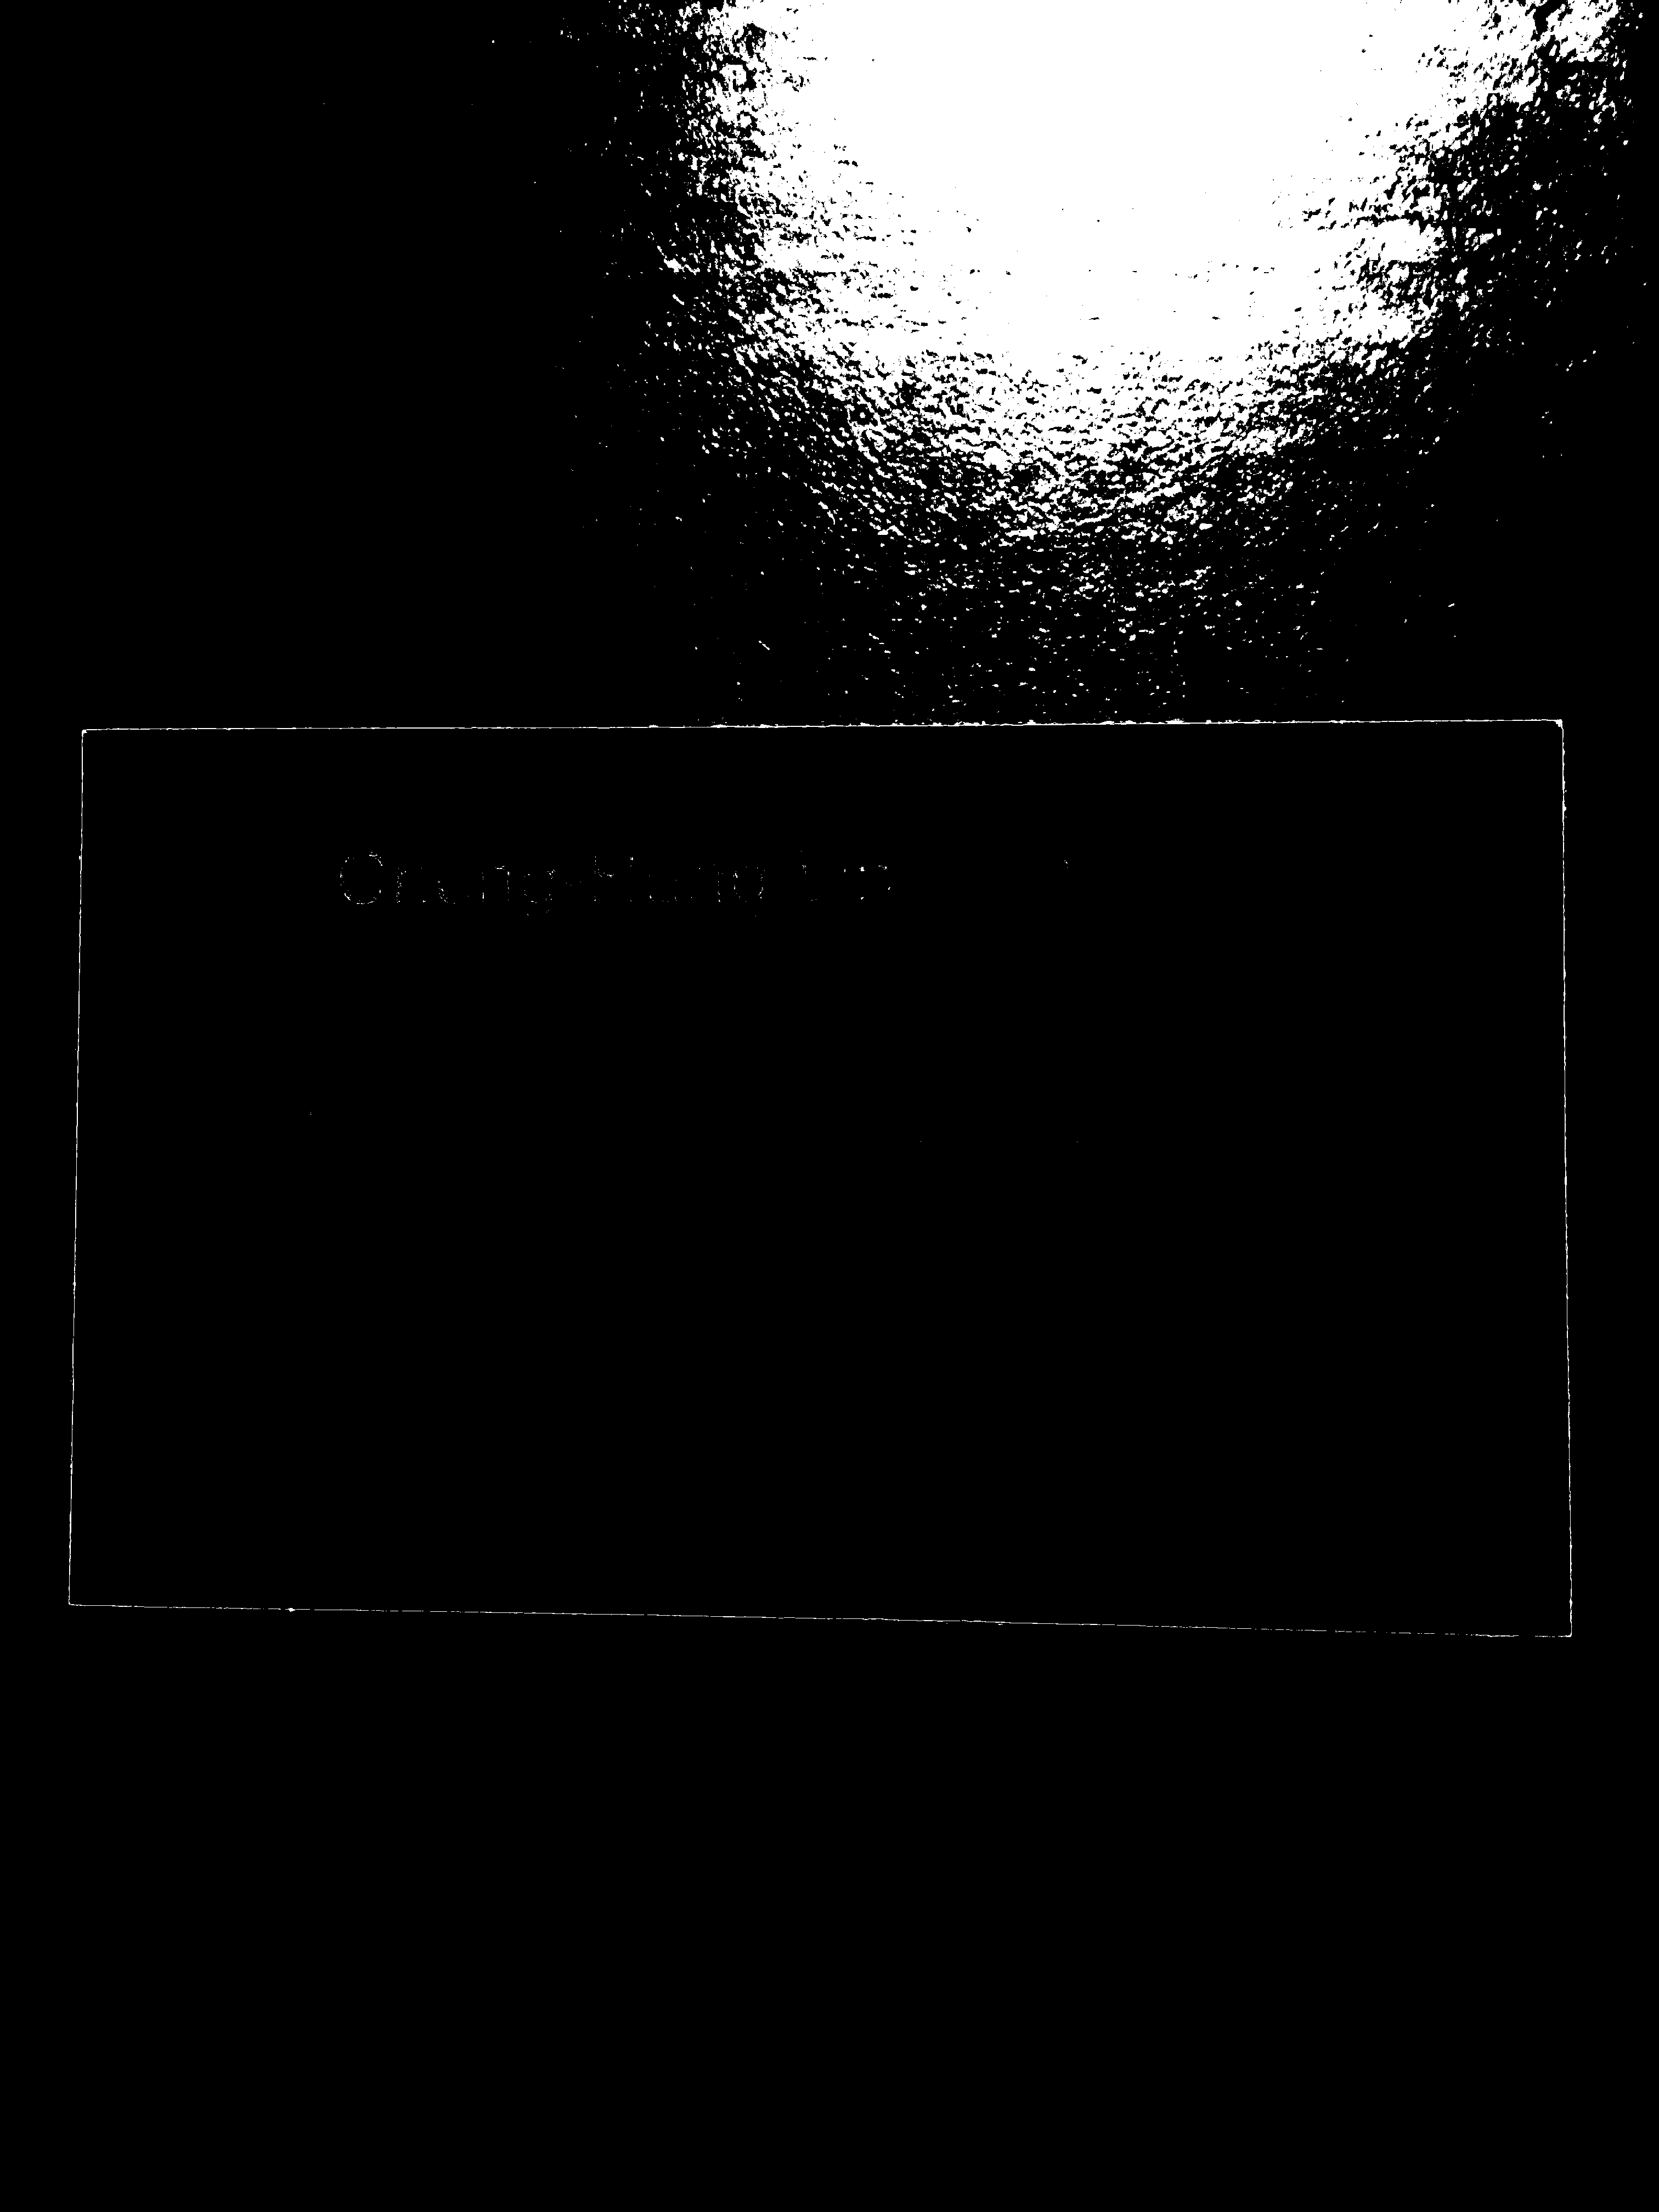

----------------------------------------
---------------Saturation---------------


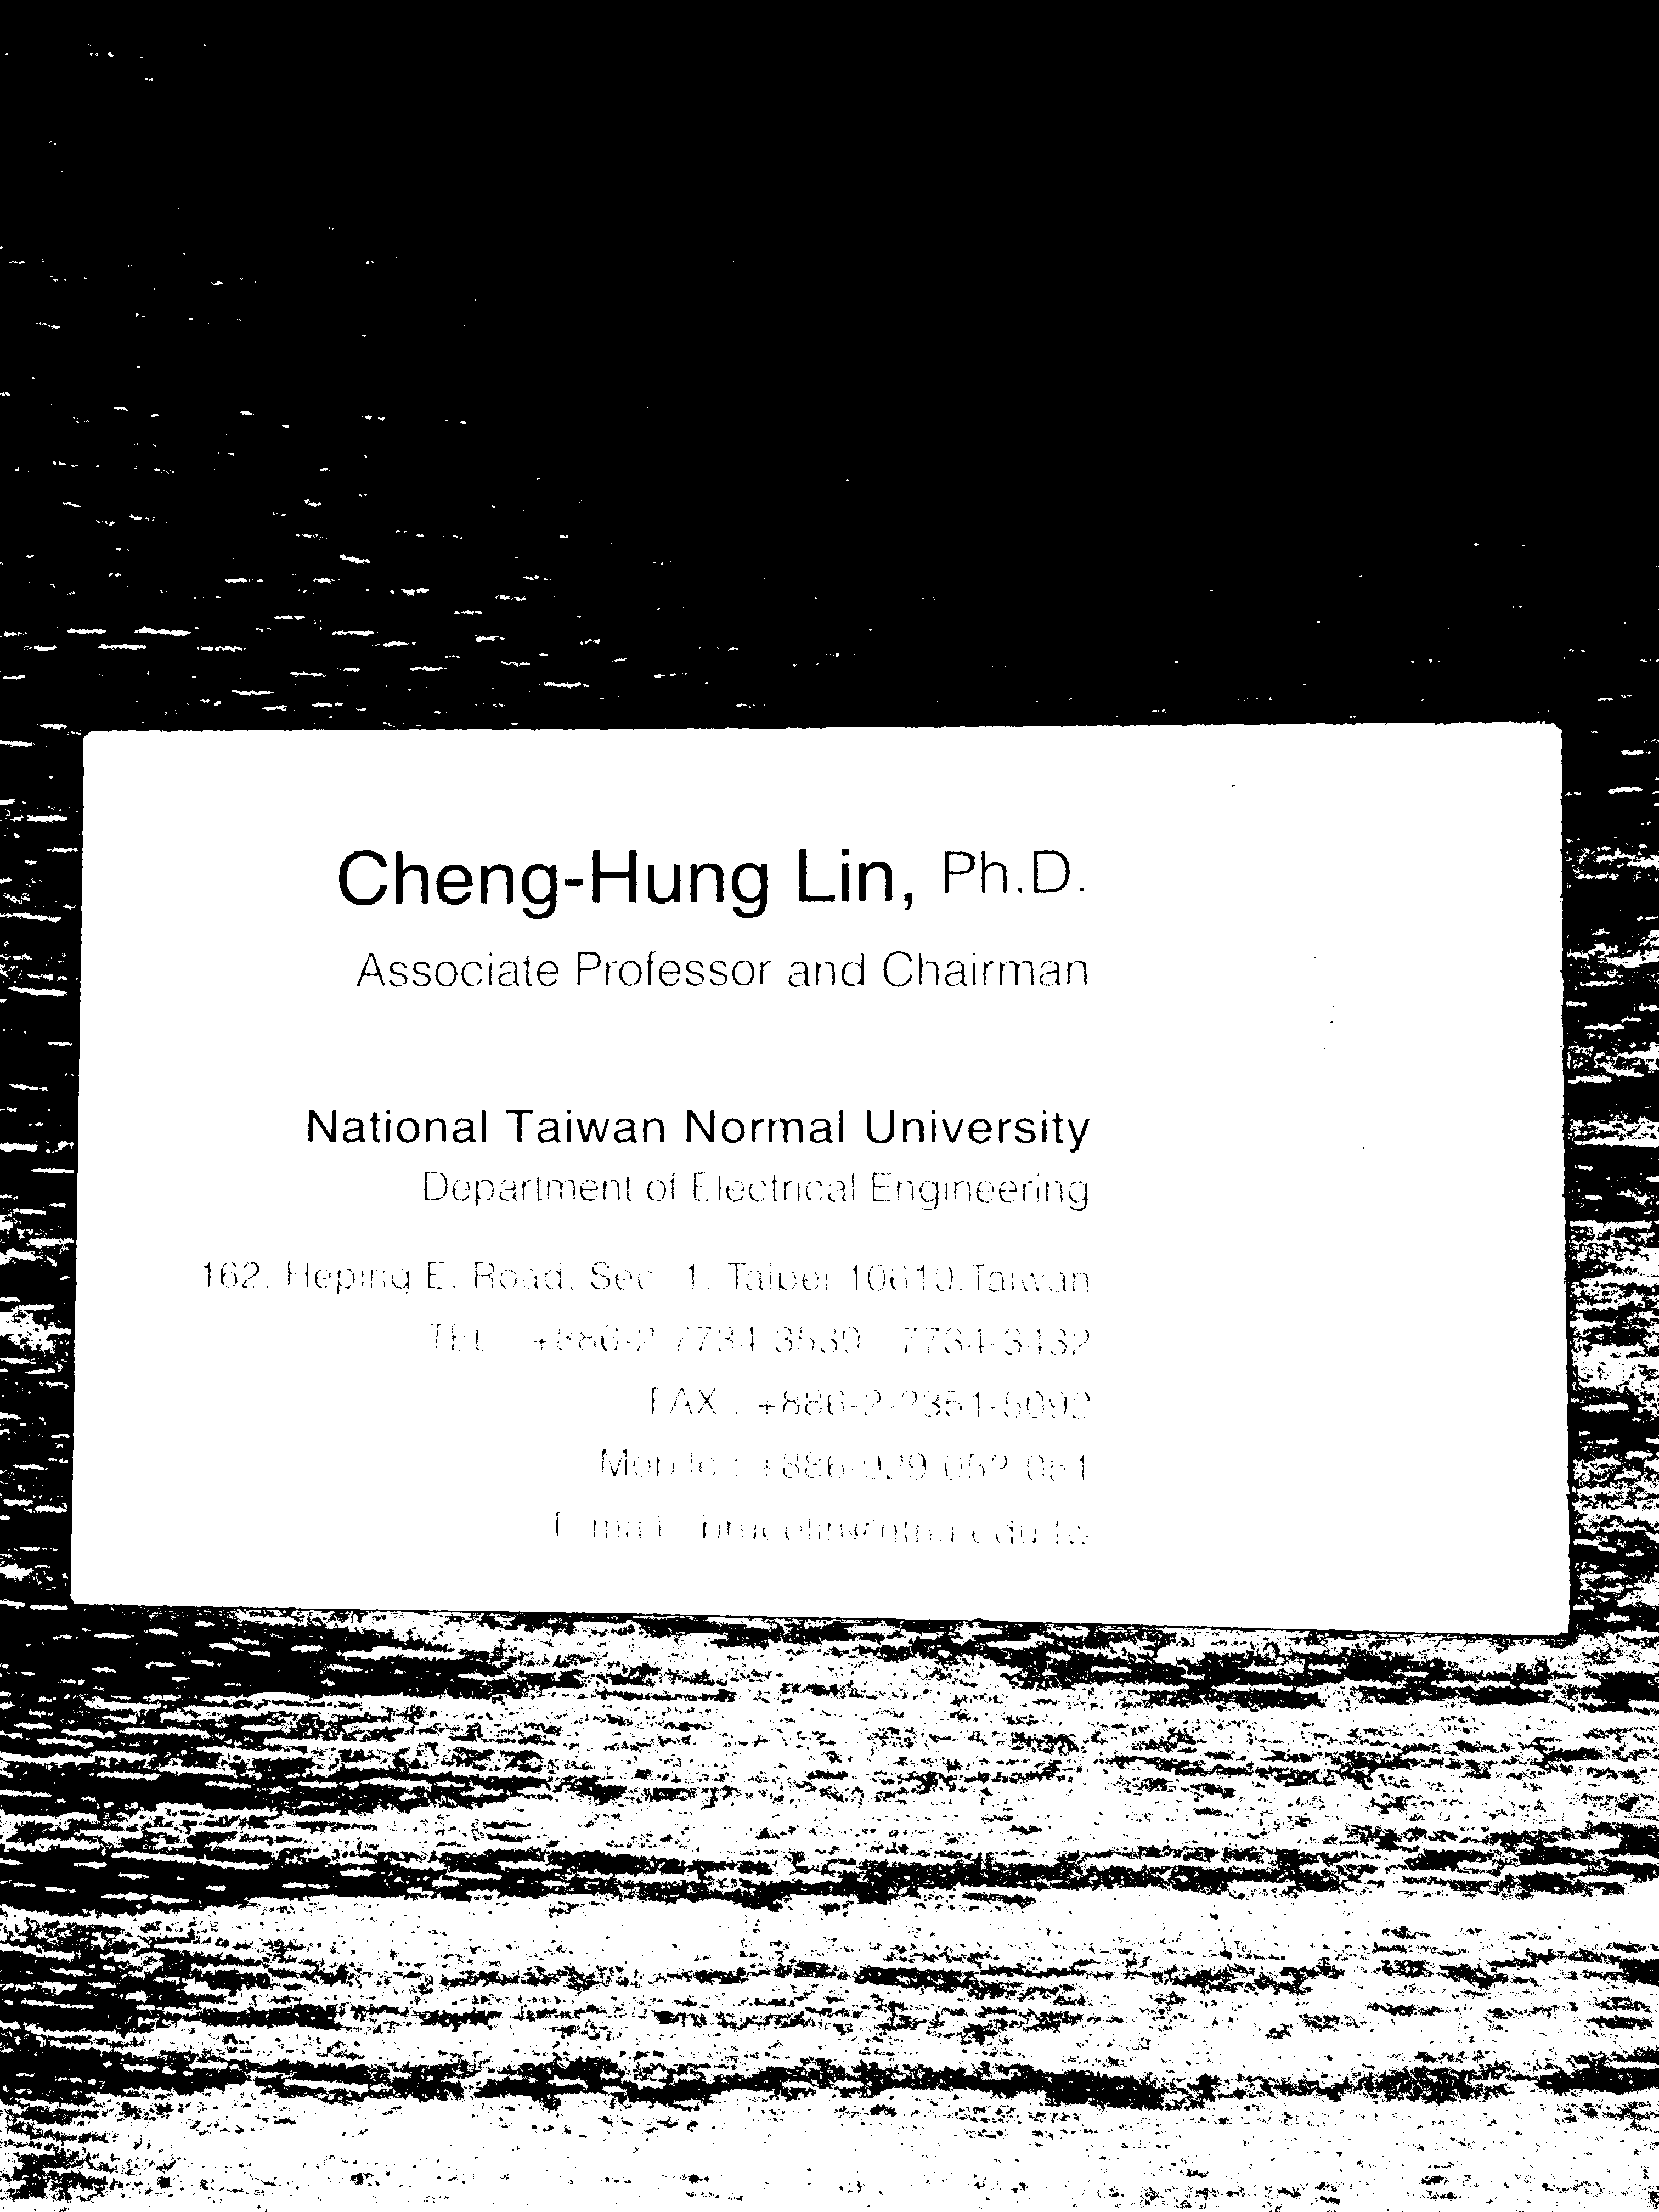

----------------------------------------


True

In [0]:
image_path = "/content/drive/My Drive/Python OpenCV/Accepted/Compar/compar3.jpg"
image = cv2.imread(image_path)
# image = cv2.resize(img,None,fx=0.75, fy=0.75, interpolation = cv2.INTER_AREA)
# image_with_contour = image.copy()
# h, s, v = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
# nonSat = (s < 70).astype(np.uint8) *255 #Find all pixel that are not very saturated
# cv2_imshow_label(nonSat, "Saturation")
# cv2_imshow_label(cv2.bitwise_not(nonSat), "not Saturation")
# # cv2_imshow(s)
# # cv2_imshow(h)
# edged = cv2.Canny(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), 100, 110, apertureSize = 3, L2gradient = True)
# cv2_imshow(edged)
# _, contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# cv2.drawContours(image_with_contour, contours, 0, (0, 0, 255), -1)
# cv2_imshow(image_with_contour)
new_image = perspective_trans(image, debug = False)
cv2.imwrite("/content/drive/My Drive/Python OpenCV/Accepted/Compar/scanCompar2.jpg", new_image)

# scale = 1
# delta = 0
# ddepth = cv2.CV_16S

# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# gray = cv2.GaussianBlur(gray, (5,5), 0)
# grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
# grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

# abs_grad_x = cv2.convertScaleAbs(grad_x)
# abs_grad_y = cv2.convertScaleAbs(grad_y)

# cv2_imshow(abs_grad_x)
# cv2_imshow(abs_grad_y)

# v = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)[:, :, 2]
# cv2_imshow(v)

# hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
# h = hsv[:, :, 0]
# s = hsv[:, :, 1]
# v = hsv[:, :, 2] -100

# # cv2_imshow(h)
# # cv2_imshow(s)

# cv2_imshow(v)

# clahe = cv2.createCLAHE(clipLimit = 30, tileGridSize = (12,12))
# cv2_imshow(clahe.apply(h))
# cv2_imshow(clahe.apply(s))
# cv2_imshow(clahe.apply(v))

# hsv_image = cv2.merge([clahe.apply(h), clahe.apply(s), clahe.apply(v)])
# out = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
# cv2_imshow(hsv_image[:, :, 2])


# original = image.copy()

# perspective_4point_trans(out)

In [0]:
test_dir = "/content/drive/My Drive/Python OpenCV/Accepted/Compar"

for indx, fname in enumerate(os.listdir(test_dir)):
  if "3" in fname:
    continue
  img = cv2.imread(os.path.join(test_dir, fname))
#   img = cv2.resize(img,None,fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
#   cv2_imshow(img)
  new_image = perspective_trans(img, debug = False)
  cv2.imwrite("/content/drive/My Drive/Python OpenCV/Accepted/Compar/scanCompar" + str(indx+1) + ".jpg", new_image)

  

error: ignored

In [0]:
# Main code
DEBUG = True
img = cv2.imread("/content/drive/My Drive/Python OpenCV/Accepted/Test/010.jpg")
# img = corrected
# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
image_with_contour = img.copy()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5,5), 0)
# homo_filter = HomomorphicFilter(a = 1, b = 5)
# img_filtered = homo_filter.filter(I=gray, filter_params=[40,2])
# cv2_imshow(img_filtered)

# edged = cv2.Canny(gray, 30, 40, apertureSize = 3, L2gradient = True)
# edged = cv2.dilate(edged, cv2.getStructuringElement(cv2.MORPH_RECT, (6,6)), iterations = 2)

kernel_elipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3)) 
morpho = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, kernel_elipse)
if DEBUG:
  cv2_imshow_label(morpho, "Morphological gradient elipse kernel")

# Thresh hold
_, thresh_otsu_morpho = cv2.threshold(morpho, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
if DEBUG:
  cv2_imshow_label(thresh_otsu_morpho, "Otsu Thresh + Morpho")

edged = thresh_otsu_morpho
edged = cv2.dilate(edged, cv2.getStructuringElement(cv2.MORPH_RECT, (6,6)), iterations = 3)

cv2_imshow(edged)

_, contours, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:4]

for contour in contours:
  p = cv2.arcLength(contour, False)
  app_contour = cv2.approxPolyDP(contour, 0.03*p, True)
  if len(app_contour) == 4 and cv2.contourArea(app_contour) > 300000:
    screenContour = app_contour
    cv2.drawContours(image_with_contour, [app_contour], 0, (0, 0, 255), 2)
    keep_doing = False
    break
    
cv2_imshow(image_with_contour)

_, s, _ = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))
nonSat = (s > 100).astype(np.uint8) *255 #Find all pixel that are not very saturated
cv2_imshow_label(nonSat, "Saturation")

Output hidden; open in https://colab.research.google.com to view.

In [0]:
test_dir = "/content/drive/My Drive/Python OpenCV/Accepted/Test"

for indx, fname in enumerate(os.listdir(test_dir)):
  if indx in list(range(25, 30)):
    print(fname)
    img = cv2.imread(os.path.join(test_dir, fname))
    h, s, v = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HSV))


    nonSat = (s < 30).astype(np.uint8) *255 #Find all pixel that are not very saturated
    # cv2_imshow(nonSat)
    disk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    nonSat = cv2.erode(nonSat.astype(np.uint8), disk)
#     nonSat = cv2.bitwise_not(nonSat)
    cv2_imshow(nonSat)

    # # WHITE == LOW SATURATION
    # v2 = v.copy()
    # v[nonSat == 0] = 0
    # cv2_imshow(v2)

In [0]:

test_dir = "/content/drive/My Drive/Python OpenCV/Accepted/Test"
out_dir = "/content/drive/My Drive/Python OpenCV/Accepted/Normalized"
# os.chdir(out_dir)
for indx, fname in enumerate(os.listdir(test_dir)):
  print(fname)
  img = cv2.imread(os.path.join(test_dir, fname))
  warped = perspective_trans(img)
  cv2.imwrite(os.path.join(out_dir, fname), warped)
  

017.jpg
002.jpg
004.jpg
005.jpg
006.jpg
007.jpg
008.jpg
009.jpg
010.jpg
011.jpg
012.jpg
013.jpg
014.jpg
015.jpg
016.jpg
018.jpg
019.jpg
021.jpg
022.jpg
023.jpg
024.jpg
025.jpg
026.jpg
029.jpg


In [0]:
6 in list(range(5,10))


True